# Type I errors for regular (unweighted) FE model and weighted FE model

I start out this notebook with the questions I have based on this part of my code. 

Then, I simulate data and perform estimation for both a regular FE model and a weighted FE model, where missing datapoints are 0-weighted. T-values and rejection rates are calculated for both models. Each part contains an explanation on my approach. At the bottom of this notebook I print the rejection rates for both models. 

In [29]:
from class_FE_regression import *
import random
random.seed(0)

## Questions
1. Why are the Type I errors not exactly equal to 0.05?
    - The type I errors for the unweighted model are consistently too high (~0.6)
        - I compare the t-values with t from a two-sided t-distribution with $df = N * T - K$ for the unweighted model
    - The type I errors for the weighted model are actually closer to 0.05, even though one would expect them to be the same as for the unweighted model

2. Is the 'weighting out' of missing observations a valid approach? 




### Data simulation
- Set the simulation parameters and simulate the data


In [30]:

N = 50
T = 10
beta = [0, 0]
K = len(beta)
min_var, max_var = 0, 2
range_theta = [0,10]
reps = int(1e5) 
## Currently not used    
shrink_factor = 0 # set > 0 to generate cross-sectional correlation of size max_var/shrink_factor
                         
# Simulate data
sim1 = panel_simulation(N, T, beta, reps, min_var, max_var, range_theta, shrink_factor)
sim1.simulate_Y()

## Regular (unweighted) FE OLS

### Estimation
- Estimates the $\beta$ coefficients 

I implement the estimation of the FE model by first applying the within transformation to the data and then estimate the model with pooled OLS. In my implementation, I use tensor contractions, which is a generalization of matrix multiplication to $n$-dimensional tensors. This is computationally much more efficient, since no for loops need to be used. It scales along every axis, e.g., $X$ has four dimensions, $X = X_{rctk}$, where $r$ = nr. of repititions, $c$ = nr. of cohorts, $t$ = nr. of timepoints, $k$ = nr. of regressors, so this approach is very efficient. Since the estimation is fast a larger part of the parameter space can be explored. 

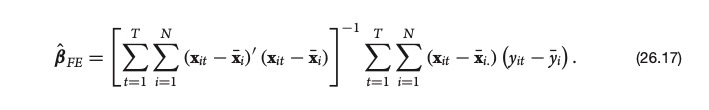
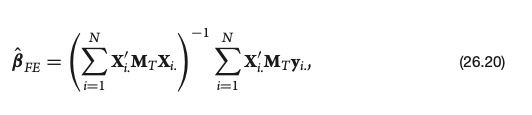

In [31]:
# Estimate coefficients 
est_unweighted = panel_estimation(sim1.X_observed, sim1.Y, N, T, method = 'FE_OLS')
est_unweighted.estimate_coefs()

### Hypothesis testing

- Calculate t-values and get the rejection rate (nr of times $\beta$ was rejected in all repetitions)

Again, this is impemented using tensor contractions to speed up the calculations. 

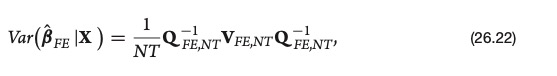

### $Q_{FE, NT}$-matrix
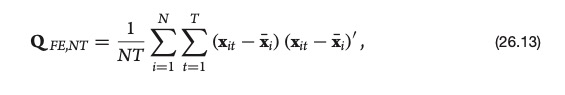


### $V_{FE, NT}$-matrix
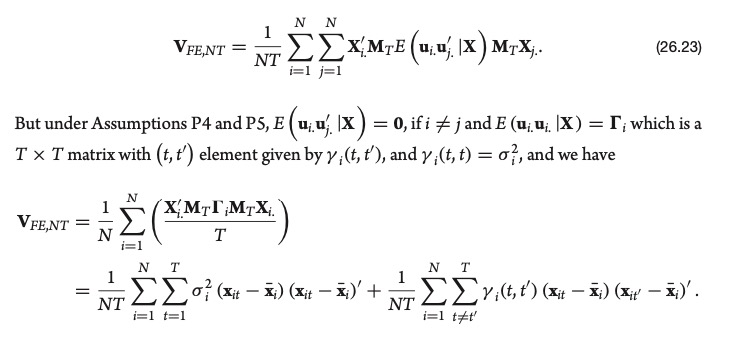

In [32]:
# Calculate the t-values
est_unweighted.calc_t_values()
# Calculate the proportion of repetitions in which H0 is rejected for each beta
est_unweighted.rejection_rate()
est_unweighted.proportion_H0_rejected

array([0.06295, 0.06472])

## Weighted FE OLS

Now, I estimate the weighted FE OLS model. The weighting is performed to account for missingness while still retaining all available datapoints. 
In survey analysis using pseudo-panel models, we see three sources of missingness:
- Survey wasn't taken in specific years for certain countries
- Cohorts are missing (e.g., no elderly women were surveyed in Czech in 2012)
- Item missingness: a respondent declined to answer a specific question

We can account for this by using Weighted Least Squares (WLS). By setting the missing datapoints to 0, they do not contribute to the sum of squares and will not affect the value of $beta$. Missing values are accounted for, all available data is retained.

In hypothesis testing we need to account for the missingness. The calculation of the t-values is slightly different as compared to unweighted FE OLS:
- Adjustment of the variance estimation for each cohort/ cross-sectional unit
    - Using the residuals, we estimate the variance for each cohort $c$, which would normally divide by T
    - However, since datapoints are missing T is not equal for all $c$
    - The adjustment to calculate the effective T for cohort $c$ works as follows:
        - $T_{effective,~c} = T - \frac{nr~of~missing~values}{nr~of~regressors}$
        - E.g., for item missingness; when we have two regressors, 15 timepoints, and for one timepoint one observation for $x$ is missing:
            - $T_{effective,~c} = 15 - \frac{1}{2} = 14.5$
- Degrees of freedom calculation
    - Since T is not equal for all $c$:
        - $df = N * \sum_{c=1}^{C} T_{effective}$


### Simulate missingness
- Set $P(missing)$, the probability that a datapoint is missing
- Randomly remove $P(missing) * N * T$ datapoints for each repitition


In [33]:
# Simulate removing missing datapoints
# Randomly select missing_prob amount of indices to set to NA for X
missing_prob = 0.1
missing_indices_X = np.random.rand(*sim1.X.shape) < missing_prob

# Set to NaN
sim1.X_observed[missing_indices_X] = np.nan

### Estimation
- Estimates the $\beta$ coefficients using the WLS procedure

The weighting matrix is a matrix of zeroes and ones, with zeroes corresponding to observations that are missing. The within-transformed data for X and Y are used. 

$\hat{\beta}_{WLS} = \left( X^\top W X \right)^{-1} X^\top W y$

In [34]:
# Estimates a FE model by assigning 0 weight to the missing datapoints
est_weighted = panel_estimation(sim1.X_observed, sim1.Y, N, T, method = 'weighted_FE_OLS')
est_weighted.estimate_coefs()

In [35]:
est_weighted.calc_t_values()
est_weighted.rejection_rate()
est_weighted.proportion_H0_rejected

array([0.0481 , 0.04756])

- Compare type I error (rejection rate) in weighted vs unweighted

In [36]:
# Compare 
print(f"Unweighted Type I error: {est_unweighted.proportion_H0_rejected}\nWeighted Type I error: {est_weighted.proportion_H0_rejected}")

Unweighted Type I error: [0.06295 0.06472]
Weighted Type I error: [0.0481  0.04756]
